## Neural Quantum Embedding via DQC1

This tutorial demonstrates the implementation of neural quantum embedding (NQE) using deterministic quantum computation with one clean qubit (DQC1). More experimental results for NQE-DQC1, including real-hardware experiments on NMR device, can be found in [this paper[1]](https://arxiv.org/abs/2501.15359). If you want to know more about NQE read the [original paper](https://arxiv.org/abs/2311.11412[2]) or follow the [introductory tutorial](https://takh04.github.io/nqe.html). If you need more information about DQC1 protocal, have a look at this [introduction](https://en.wikipedia.org/wiki/One_clean_qubit). 

This tutorial was tested under following environments:
```
python=3.10
pennylane==0.27.0
torch==2.7.1
tensorflow==2.19.0
scikit-learn==1.7.0
seaborn==0.13.2
```

## 0. Introduction

NQE tries to find the optimal quantum embedding that maximizes the trace distance between classes. To do this, NQE protocol minimizes a implicit loss function motivated by fidelity overlap between two quantum states, 
$$d_{\mathrm{fid}}(x_i, x_j) = \mathrm{Tr}\left(\rho(x_i)^\dagger \rho(x_j)\right)$$, 
where $\rho(x) = U(x)\vert 0 \rangle^{\otimes n}$ for some quantum embedding function $U$.

Instead of directly using the fidelity, we can consider using a distance between two quantum embeddings, 
$$ d_{\mathrm{HS}}(x_i, x_j) = \frac{1}{2^n}\mathrm{Tr}\left(U^\dagger(x_i) U(x_j)\right).$$
This is also known as a Hilbert-Schmidt distance.

Deterministic quantum computation with one clean qubit (DQC1), despite being a subuniversal quantum computation, can compute interesting quantities that classical computers can not. One of them is computing the trace of an exponentially large unitary matrix, and we will use it to compute the Hilbert-Schmidt distance between quantum embeddings.

<div style="text-align: center;">
  <img src="nqe-dqc1.png" style="height:500px">
</div>

All the contents of NQE-DQC1 demo is almost exactly same as the original [NQE demo](https://takh04.github.io/nqe.html). The only difference is we use Hilbert-Schmidt distance between quantum embeddings, instead of quantum state overlap. So I will skip details.

### Data loading and preprocessing

In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch import nn
from sklearn.decomposition import PCA
import tensorflow as tf

np.random.seed(42)
torch.manual_seed(42)
def data_load_and_process():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0
    train_filter_tf = np.where((y_train == 0 ) | (y_train == 1 ))
    test_filter_tf = np.where((y_test == 0 ) | (y_test == 1 ))
 
    x_train, y_train = x_train[train_filter_tf], y_train[train_filter_tf]
    x_test, y_test = x_test[test_filter_tf], y_test[test_filter_tf]

    x_train = tf.image.resize(x_train[:], (256, 1)).numpy()
    x_test = tf.image.resize(x_test[:], (256, 1)).numpy()
    x_train, x_test = tf.squeeze(x_train).numpy(), tf.squeeze(x_test).numpy()
        
    X_train = PCA(4).fit_transform(x_train)
    X_test = PCA(4).fit_transform(x_test)
    x_train, x_test = [], []
    for x in X_train:
        x = (x - x.min()) * (np.pi / (x.max() - x.min()))
        x_train.append(x)
    for x in X_test:
        x = (x - x.min()) * (np.pi / (x.max() - x.min()))
        x_test.append(x)
    return x_train, x_test, y_train, y_test

#load data
X_train, X_test, Y_train, Y_test = data_load_and_process()
X_train, X_test, Y_train, Y_test = X_train[0:400], X_test[0:100], Y_train[0:400], Y_test[0:100]

/Users/tak/anaconda3/envs/new/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


### Define Quantum Embedding and NQE-DQC1

Define IQP type Quantum Embedding (ZZ Feature Map).

In [2]:
N_layers = 3
# exp(ixZ) gate
def exp_Z(x, wires):
    qml.RZ(-2 * x, wires=wires)

# exp(i(pi - x1)(pi - x2)ZZ) gate
def exp_ZZ(x1, x2, wires):
    qml.CNOT(wires=wires)
    qml.RZ(-2 * (np.pi - x1) * (np.pi - x2), wires=wires[1])
    qml.CNOT(wires=wires)

def QuantumEmbedding(input):
    for i in range(N_layers):
        for j in range(4):
            qml.Hadamard(wires=j)
            exp_Z(input[j], wires=j)
        for k in range(3):
            exp_ZZ(input[k], input[k+1], wires=[k,k+1])
        exp_ZZ(input[3], input[0], wires=[3, 0])

Define NQE-DQC1.

In [3]:
dev = qml.device('default.qubit', wires=4)
@qml.qnode(dev, interface="torch")
def circuit(inputs): 
    QuantumEmbedding(inputs[0:4])
    qml.adjoint(QuantumEmbedding)(inputs[4:8])
    return qml.probs(wires=range(4))

class Model_HS(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1 = qml.qnn.TorchLayer(circuit, weight_shapes={})
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8,8),
            nn.ReLU(),
            nn.Linear(8,4)
        )
        self.matrix_fn = qml.matrix(circuit)

    def forward(self, x1, x2):
        x1 = self.linear_relu_stack1(x1)
        x2 = self.linear_relu_stack1(x2)
        x = torch.concat([x1, x2], 1)
        x = [torch.real(torch.trace(self.matrix_fn(a))) for a in x]
        x = torch.stack(x, dim = 0)
        return x / 2**4

The only modification from the original demo is this line of code.
```
x = [torch.real(torch.trace(self.matrix_fn1(a))) for a in x]
```
Unlike the original demo, we are computing trace of an unitary, which measures the Hilbert-Schmidt distance.

### Optimize NQE

In [4]:
batch_size = 25
iterations = 200


#make new data for hybrid model
def new_data(batch_size, X, Y):
    X1_new, X2_new, Y_new = [], [], []
    for i in range(batch_size):
        n, m = np.random.randint(len(X)), np.random.randint(len(X))
        X1_new.append(X[n])
        X2_new.append(X[m])
        if Y[n] == Y[m]:
            Y_new.append(1)
        else:
            Y_new.append(0)
    X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)
    return X1_new, X2_new, Y_new


model = Model_HS()
model.train()

loss_fn = torch.nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr=0.01)
for it in range(iterations):
    X1_batch, X2_batch, Y_batch = new_data(batch_size, X_train, Y_train)
    pred = model(X1_batch, X2_batch)
    loss = loss_fn(pred, Y_batch)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if it % 50 == 0:
        print(f"Iterations: {it} Loss: {loss.item()}")

    
torch.save(model.state_dict(), "model.pt")

/var/folders/s2/t3n82l2s329dh9dttmtv7vr00000gn/T/ipykernel_22387/3446470592.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)


Iterations: 0 Loss: 0.17514556646347046
Iterations: 50 Loss: 0.06814505159854889
Iterations: 100 Loss: 0.03293833136558533
Iterations: 150 Loss: 0.048714496195316315


### Train QCNN with and without NQE-DQC1

In [5]:
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

class x_transform(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )
        
    def forward(self, x):
        x = self.linear_relu_stack1(x)
        return x.detach().numpy()

model_transform = x_transform()
model_transform.load_state_dict(torch.load("model.pt"))

def statepreparation(x, NQE):
    if NQE:
        x = model_transform(torch.tensor(x))
    QuantumEmbedding(x)

def U_SU4(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])
    
def QCNN(params):    
    param1 = params[0:15]
    param2 = params[15:30]
    
    U_SU4(param1, wires=[0, 1])
    U_SU4(param1, wires=[2, 3])
    U_SU4(param1, wires=[1, 2])
    U_SU4(param1, wires=[3, 0])
    U_SU4(param2, wires=[0, 2])
    

@qml.qnode(dev)
def QCNN_classifier(params, x, NQE):
    statepreparation(x, NQE)
    QCNN(params)
    return qml.expval(qml.PauliZ(2))

steps = 100
learning_rate = 0.01
batch_size = 25

def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)

def cost(weights, X_batch, Y_batch, Trained):
    preds = [QCNN_classifier(weights, x, Trained) for x in X_batch]
    return Linear_Loss(Y_batch, preds)


def circuit_training(X_train, Y_train, Trained):
    weights = np.random.random(30, requires_grad = True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, Trained),
                                                     weights)
        loss_history.append(cost_new)
        if it % 50 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history, weights

loss_history_without_NQE, weight_without_NQE = circuit_training(X_train, Y_train, Trained=False)
loss_history_with_NQE, weight_with_NQE = circuit_training(X_train, Y_train, Trained=True)

/Users/tak/anaconda3/envs/new/lib/python3.10/site-packages/autograd/numpy/numpy_vjps.py:943: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


iteration:  0  cost:  0.47305071882302285
iteration:  50  cost:  0.4285454994628626
iteration:  0  cost:  0.4905605640588162
iteration:  50  cost:  0.34384188182799086


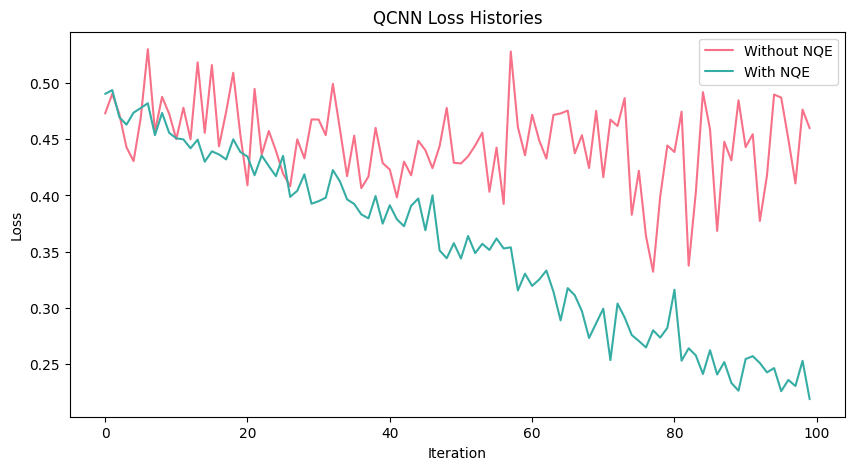

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 2)
with sns.axes_style("darkgrid"):
    ax.plot(range(len(loss_history_without_NQE)), loss_history_without_NQE, label="Without NQE", c=clrs[0])
    ax.plot(range(len(loss_history_with_NQE)), loss_history_with_NQE, label="With NQE", c=clrs[1])

ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("QCNN Loss Histories")
ax.legend()

In [7]:
def accuracy_test(predictions, labels):
    acc = 0
    for l, p in zip(labels, predictions):
        if np.abs(l - p) < 1:
            acc = acc + 1
    return acc / len(labels)


accuracies_without_NQE, accuracies_with_NQE = [], []

prediction_without_NQE = [QCNN_classifier(weight_without_NQE, x, NQE=False) for x in X_test]
prediction_with_NQE = [QCNN_classifier(weight_with_NQE, x, NQE=True) for x in X_test]

accuracy_without_NQE = accuracy_test(prediction_without_NQE, Y_test) * 100
accuracy_with_NQE = accuracy_test(prediction_with_NQE, Y_test) * 100

print(f"Accuracy without NQE: {accuracy_without_NQE:.3f}")
print(f"Accuracy with NQE: {accuracy_with_NQE:.3f}")

Accuracy without NQE: 61.000
Accuracy with NQE: 98.000


As expected, NQE-DQC1 effectively optimizes the quantum embedding and improve the classification performance!

### References

1. Tak Hur, Israel F. Araujo, Daniel K. Park. *Neural Quantum Embedding: Pushing the Limits of Quantum Supervised Learning*. Physical Review A (2024).
2. Hongfeng Liu, Tak Hur, Shitao Zhang. *Neural quantum embedding via deterministic quantum computation with one qubit*. arXiv.2501.15359

### Citation

If you use this code in your research, please cite our paper:
```
@article{liu2025neural,
  title={Neural quantum embedding via deterministic quantum computation with one qubit},
  author={Liu, Hongfeng and Hur, Tak and Zhang, Shitao and Che, Liangyu and Long, Xinyue and Wang, Xiangyu and Huang, Keyi and Fan, Yu-ang and Zheng, Yuxuan and Feng, Yufang and others},
  journal={arXiv preprint arXiv:2501.15359},
  year={2025}
}
```